In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()
from matplotlib.dates import DateFormatter
# -----------------------------------------------------------------------------------
# Load the patient level table
# -----------------------------------------------------------------------------------
root_dir = "H:/Research/Hand_dirty/SAH_data/"
patient = pd.read_csv(
        root_dir+"patient_encounter/Pat_file_ENC.csv")

patient['PATIENT_SK'].nunique()                      # 4810
SAH_ENC_screened_24h_rule = pd.read_csv(
  root_dir+"patient_encounter/SAH_ENC_screened_24h_rule.csv")
SAH_ENC_screened_24h_rule['PATIENT_SK'].nunique()    # 4810
SAH_ENC_screened_24h_rule['ENCOUNTER_ID'].nunique()  # 4823
SAH_ENC_screened_24h_rule.shape
# Get a new patient level table by adding information such as encounter ID
pat_enc_final = pd.merge(patient, SAH_ENC_screened_24h_rule, on='PATIENT_SK')
pat_enc_final.shape

(4823, 57)

In [3]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = 10
enc_med_cl2 = pd.read_csv(root_dir+'medication/sah_pts_enc_med_sl_ad_cl2.tsv',
                          delimiter='\t')
enc_med_cl3 = pd.read_csv(root_dir+'medication/sah_pts_all_enc_med_cl3_v2.tsv',
                          delimiter='\t')
# In order to get the dose quantity,
# we need to merge some columns between enc_med_cl2 and enc_med_cl3
enc_med_cl2 = pd.merge(enc_med_cl2, enc_med_cl3[['INDEX_ID', 'DOSE_QUANTITY',
                       'ORDER_NO', 'TOTAL_DISPENSED_DOSES', 'CREDIT_QUANTITY',
                       'CHARGE_QUANTITY', 'INFUSION_RATE', 'INFUSION_TIME',
                       'DOSE_FORM_DESCRIPTION', 'ROUTE_DESCRIPTION',
                       'INITIAL_DOSE_QUANTITY']],
                        on='INDEX_ID')

In [4]:
# Medication id
enc_med_cl2['MEDICATION_ID'].nunique()  # 70
enc_med_cl2.groupby('GENERIC_NAME')['MEDICATION_ID'].nunique()
# Load NDC_codes information
vasopressor_ndc_codes = pd.read_csv(
        root_dir+'medication/list of vasopressors with ndc codes.tsv',
        delimiter='\t')
vasopressor_ndc_codes = vasopressor_ndc_codes[[
        'MEDICATION_ID', 'NDC_CODE']].drop_duplicates()
vasopressor_ndc_codes['MEDICATION_ID'].nunique()
vasopressor_ndc_codes['NDC_CODE'].nunique()
enc_med_cl2 = pd.merge(vasopressor_ndc_codes, enc_med_cl2, on='MEDICATION_ID',
                       how='inner')
# NDC code:0517-1805-25 to verify my theory of unit strength
enc_med_cl2['PRODUCT_STRENGTH_DESCRIPTION'] = enc_med_cl2[
        'PRODUCT_STRENGTH_DESCRIPTION'].str.replace("mL", "ml")

In [5]:
def bar_annotation(ax, option='number'):
    '''
    This function is to add according number or percentage on every bar
    option: number or percentage, default is number
    ax: the figure object
    '''
    try:
        if option == 'number':
            for i in ax.patches:
                ax.text(i.get_x(), i.get_height()+.5, i.get_height(),
                         fontsize=15, color='dimgrey')
        if option == 'percentage':
            totals = []
            for i in ax.patches:
                totals.append(i.get_height())
                total = sum(totals)
            for i in ax.patches:
                ax.text(i.get_x(), i.get_height()+.5,
                        str(round((i.get_height()/total)*100, 2))+'%',
                        fontsize=15, color='dimgrey')
    except:
        return('inputs are wrong')


def total_seconds(time):
    '''
    Convert the resolution of time to hours
    '''
    return time.total_seconds()/3600
enc_med_cl2['MED_STARTED_DT_TM'] = pd.to_datetime(
        enc_med_cl2['MED_STARTED_DT_TM'])
start_tm_na_ind = (enc_med_cl2['MED_STARTED_DT_TM'].apply(str)
                   == '01-JAN-1000 00:00:00')
stop_tm_na_ind = (enc_med_cl2['MED_STOPPED_DT_TM'].apply(str)
                  == '01-JAN-1000 00:00:00')
enc_med_cl2['MED_STOPPED_DT_TM'][stop_tm_na_ind] = np.nan
enc_med_cl2['MED_STOPPED_DT_TM'] = pd.to_datetime(
        enc_med_cl2['MED_STOPPED_DT_TM'])
enc_med_cl2['stop_start_gap'] = enc_med_cl2['MED_STOPPED_DT_TM'] -\
                 enc_med_cl2['MED_STARTED_DT_TM']
enc_med_cl2['stop_start_gap'] = enc_med_cl2['stop_start_gap'].\
                                apply(total_seconds)

C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
enc_med_cl2['UNIT_STRENGTH'] = enc_med_cl2.eval('ORDER_STRENGTH/DOSE_QUANTITY')
enc_med_cl2['TOTAL_CONSUMED_STRENGTH'] = enc_med_cl2.eval(
                                        'UNIT_STRENGTH *CONSUMED_QUANTITY')

In [7]:
pat_enc_med = pd.merge(pat_enc_final[['PATIENT_SK', 'ENCOUNTER_ID']],
                       enc_med_cl2, on='ENCOUNTER_ID')
pat_enc_med['MED_STARTED_DT_TM'] = pd.to_datetime(
                                   pat_enc_med['MED_STARTED_DT_TM'])
pat_enc_med = pat_enc_med.sort_values(by='MED_STARTED_DT_TM')
group_by_patientsk = pat_enc_med.groupby('PATIENT_SK')

# Get the number of types of treatments one patient received
treatment_types_per_patient = group_by_patientsk['GENERIC_NAME'].nunique()

In [8]:
# Extract the patients who have only been assigned one type of treatment
one_type_treatment = pat_enc_med[pat_enc_med['PATIENT_SK'].isin(
       treatment_types_per_patient[treatment_types_per_patient == 1].index)]
# The number of patients who only been assigned one type of treatment
one_type_treatment.shape[0]  # 5813
one_type_treatment['PATIENT_SK'].nunique()  # 3293
one_type_treatment['TOTAL_CONSUMED_STRENGTH'].describe()
# First see how many observations whose total consumed strengths are available
one_type_treatment_valid_tcs = one_type_treatment.query(
        'TOTAL_CONSUMED_STRENGTH>0')
one_type_treatment_valid_tcs.shape[0]  # 3309
one_type_treatment_valid_tcs['PATIENT_SK'].nunique()  # 1839
# To calculate the frequency of the vasopressors for every patient
one_type_treatment_groupby_pat = one_type_treatment_valid_tcs.groupby(
        'PATIENT_SK')
one_type_treatment_vaspsr_counts = one_type_treatment_groupby_pat[
        'GENERIC_NAME'].value_counts()

# Analysis for patients received one type of treatment

In [9]:
print('The number of patients who only received one type of treatment: \n{}.'.format(one_type_treatment['PATIENT_SK'].nunique()))
print('The number of patients who only received one type of treatment and have total consumed strength > 0: \n{}.'.format(
one_type_treatment_valid_tcs['PATIENT_SK'].nunique()))

The number of patients who only received one type of treatment: 
3293.
The number of patients who only received one type of treatment and have total consumed strength > 0: 
1839.


## For the 1839 patients

### Order frequency

Note that following figure is for the whole three treatments

Text(0,0.5,'Counts of patients')

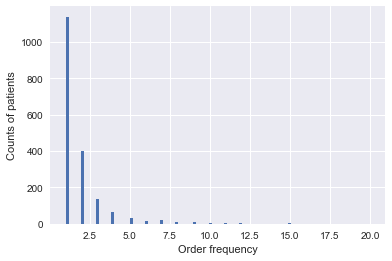

In [10]:
# The distribution of the medication frequency
ax = one_type_treatment_vaspsr_counts.hist(bins=100)
ax.set_xlabel('Order frequency')
ax.set_ylabel('Counts of patients')

In terms of different type of treatments

Text(0,0.5,'Counts of patients')

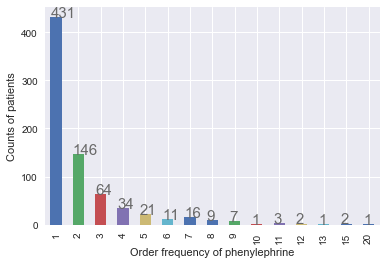

In [11]:
one_type_treatment_vaspsr_counts = one_type_treatment_vaspsr_counts.rename(
        "medication_frequency")
one_type_treatment_vaspsr_counts = one_type_treatment_vaspsr_counts\
                                  .reset_index()
# The distribution of the three types of treatments
one_type_treatment_vaspsr_counts['GENERIC_NAME'].value_counts()
# Since output of the fucntion df.describe() in a loop is strange, I do not
# use the loop here
treatment_types = one_type_treatment_vaspsr_counts['GENERIC_NAME'].unique()
ax = pd.value_counts(one_type_treatment_vaspsr_counts.query('GENERIC_NAME == @treatment_types[0]')[
        'medication_frequency'], sort=False).plot(kind='bar')
bar_annotation(ax, 'number')
ax.set_xlabel('Order frequency of phenylephrine')
ax.set_ylabel('Counts of patients')

Text(0,0.5,'Counts')

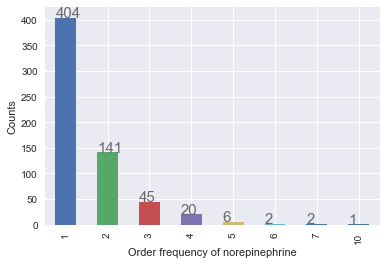

In [12]:
ax = pd.value_counts(one_type_treatment_vaspsr_counts.query('GENERIC_NAME == @treatment_types[1]')[
        'medication_frequency'], sort=False).plot(kind='bar')
bar_annotation(ax, 'number')
ax.set_xlabel('Order frequency of norepinephrine')
ax.set_ylabel('Counts')

Text(0,0.5,'Counts of patients')

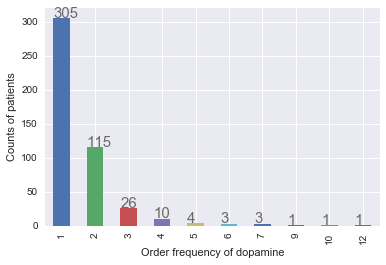

In [13]:
ax = pd.value_counts(one_type_treatment_vaspsr_counts.query('GENERIC_NAME == @treatment_types[2]')[
        'medication_frequency'], sort=False).plot(kind='bar')
bar_annotation(ax, 'number')
ax.set_xlabel('Order frequency of dopamine')
ax.set_ylabel('Counts of patients')

### Time gap between different orders for every encounter

#### Distribution 

The unit of the order_time_diff is Hour here.

In [14]:
time_diff = []
for patient_sk, data in one_type_treatment_groupby_pat:
    if data.shape[0] > 1:
        temp_time_diff = data['MED_STARTED_DT_TM'].shift(-1)\
                         - data['MED_STARTED_DT_TM']
        temp_time_diff = pd.DataFrame(temp_time_diff.dropna())
        temp_time_diff['PATIENT_SK'] = patient_sk
        time_diff.append(temp_time_diff)
time_diff = pd.concat(time_diff)
time_diff.rename(columns={"MED_STARTED_DT_TM": "order_time_diff"}, inplace=True)
def total_seconds(time):
    '''
    Convert the resolution of time to hours
    '''
    return time.total_seconds()/3600


time_diff["order_time_diff"] = time_diff["order_time_diff"].apply(total_seconds)
time_diff[["order_time_diff"]].describe()

,order_time_diff
count,1470.000000
mean,39.690499
std,113.290220
min,0.000000
25%,1.000000
50%,7.000000
75%,28.000000
max,1743.883333


Text(0,0.5,'Counts')

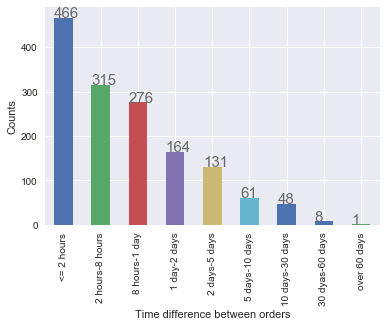

In [15]:
bins = [-0.000001, 2, 8, 1*24, 2*24, 5*24, 10*24,
        30*24, 60*24, 1744]
time_interval = ['<= 2 hours', '2 hours-8 hours', '8 hours-1 day',
                 '1 day-2 days', '2 days-5 days', '5 days-10 days',
                 '10 days-30 days', '30 dyas-60 days', 'over 60 days']
cutted_time_diff = pd.cut(time_diff["order_time_diff"], bins,
                          labels=time_interval)
ax = cutted_time_diff.value_counts().plot(kind='bar')
bar_annotation(ax)
ax.set_xlabel('Time difference between orders')
ax.set_ylabel('Counts')

#### Time difference is 0

In [16]:
time_diff_equal_0 = time_diff.query('order_time_diff == 0')
time_diff_equal_0.shape
print('The number of patients who has dulplicate order time : {} '.format(time_diff_equal_0['PATIENT_SK'].nunique()))


The number of patients who has dulplicate order time : 46 


Check it in detail

In [17]:
# First extract the patients who has dulplicate medication time
table_contains_same_med = one_type_treatment[
        one_type_treatment['PATIENT_SK'].isin(time_diff_equal_0['PATIENT_SK'])]
# the indicator of the dulplicate medication time
indicator1 = table_contains_same_med.duplicated(
        'MED_STARTED_DT_TM', keep=False)
# Get the table of all the observations with same medication start time
same_medstarttime = table_contains_same_med[indicator1]
same_medstarttime

,PATIENT_SK,ENCOUNTER_ID,MEDICATION_ID,NDC_CODE,INDEX_ID,...,ROUTE_DESCRIPTION,INITIAL_DOSE_QUANTITY,stop_start_gap,UNIT_STRENGTH,TOTAL_CONSUMED_STRENGTH
1121,3194108,4064529,12895,641048225,134880590,...,injectable,1,0.000000,10.000,40.000
1122,3194108,4064529,12895,641048225,134880591,...,injectable,1,0.000000,10.000,40.000
2937,8442845,45489407,22082,74180001,290781327,...,injectable,1,78.116667,10.000,300.000
2932,8442845,45489407,22082,74180001,291173655,...,injectable,1,36.000000,10.000,150.000
2898,8371805,45722307,22082,74180001,286733591,...,injectable,1,30.000000,10.000,50.000
2896,8371805,45722307,22082,74180001,286729505,...,injectable,1,0.000000,2.000,2.000
9534,41705990,136866640,28413,74780922,79379524,...,intravenous,0,30.700000,400.000,400.000
9533,41705990,136866640,28413,74780922,79387867,...,intravenous,1,0.000000,400.000,400.000
3226,8837524,45677942,22082,74180001,127152495,...,injectable,1,0.000000,2.000,2.000
3224,8837524,45677942,22082,74180001,127177260,...,injectable,1,17.100000,10.000,200.000


Get the  table of all the observations with same medication start time of , dose information, but not considering medication enter time or stop time.

In [18]:
indicator2 = table_contains_same_med.duplicated(
        ['MED_STARTED_DT_TM', 'ORDER_STRENGTH', 'DOSE_QUANTITY',
         'CONSUMED_QUANTITY'], keep=False)
same_medstarttime_dose = table_contains_same_med[indicator2]
print('The number of patients in this scenario: {}'.format(same_medstarttime_dose.shape[0]))

The number of patients in this scenario: 42


See those observations with the difference of adjacent order time less than a threshold, say 20 minutes, but not including the 0

In [19]:
bins1 = [0, 2/60, 5/60, 10/60, 20/60]
time_interval1 = ['0-2 minutes', '2-5 minutes', '5-10 minutes',
                  '10-20 minutes']
cutted_time_diff1 = pd.cut(time_diff["order_time_diff"], bins1,
                           labels=time_interval1)
cutted_time_diff1.value_counts()

10-20 minutes    53
5-10 minutes     52
0-2 minutes      45
2-5 minutes      35
Name: order_time_diff, dtype: int64

See those observations with the difference of adjacent medication time greater than a threshold, say 60 days

In [20]:
time_diff_larger60d = time_diff.query('order_time_diff > 60*24')
large_time_diff = one_type_treatment[one_type_treatment['PATIENT_SK'].isin(
        time_diff_larger60d['PATIENT_SK'])]
large_time_diff[['NDC_CODE', 'DOSE_QUANTITY', 'CONSUMED_QUANTITY',
             'TOTAL_DISPENSED_DOSES', 'ORDER_STRENGTH', 'ORDER_VOLUME',
             'PRODUCT_STRENGTH_DESCRIPTION', 'ROUTE_DESCRIPTION']]

,NDC_CODE,DOSE_QUANTITY,CONSUMED_QUANTITY,TOTAL_DISPENSED_DOSES,ORDER_STRENGTH,ORDER_VOLUME,PRODUCT_STRENGTH_DESCRIPTION,ROUTE_DESCRIPTION
11134,74144304,2,4,2,8.0,8.0,1 mg/ml,intravenous
11133,74144304,2,2,1,8.0,8.0,1 mg/ml,intravenous


### Total consumed strength(of an order)

Text(0,0.5,'Counts of order')

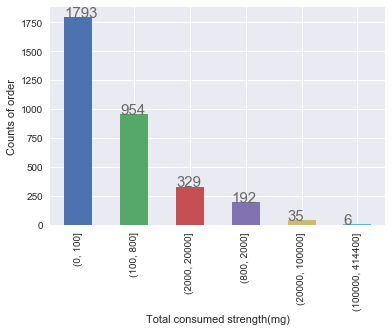

In [23]:
one_type_treatment_valid_tcs['TOTAL_CONSUMED_STRENGTH'].describe()
bins = [0, 100, 800, 2000, 20000, 100000, 414400]
bins_counts_tcs = pd.cut(
        one_type_treatment_valid_tcs['TOTAL_CONSUMED_STRENGTH'], bins)
ax = pd.value_counts(bins_counts_tcs).plot(kind='bar')
bar_annotation(ax)
ax.set_xlabel('Total consumed strength(mg)')
ax.set_ylabel('Counts of order')

In [25]:
one_type_treatment_valid_tcs_max = one_type_treatment_valid_tcs.query(
        'TOTAL_CONSUMED_STRENGTH>100000')
one_type_treatment_valid_tcs_max[['NDC_CODE', 'DOSE_QUANTITY', 'CONSUMED_QUANTITY',
             'TOTAL_DISPENSED_DOSES', 'ORDER_STRENGTH', 'ORDER_VOLUME',
             'PRODUCT_STRENGTH_DESCRIPTION', 'ROUTE_DESCRIPTION']]


,NDC_CODE,DOSE_QUANTITY,CONSUMED_QUANTITY,TOTAL_DISPENSED_DOSES,ORDER_STRENGTH,ORDER_VOLUME,PRODUCT_STRENGTH_DESCRIPTION,ROUTE_DESCRIPTION
11122,74781022,1,140,70,800.0,10.0,5%-320 mg/100 ml,intravenous
10833,74781022,1,518,259,800.0,10.0,5%-320 mg/100 ml,intravenous
11288,74781022,1,168,84,800.0,10.0,5%-320 mg/100 ml,intravenous
10332,74781022,1,252,126,800.0,10.0,5%-320 mg/100 ml,intravenous
4889,74426501,1,144,72,800.0,5.0,80 mg/ml,intravenous
1903,338100902,1,203,203,800.0,250.0,5%-320 mg/100 ml,intravenous


### Consumed quantity(of an order)

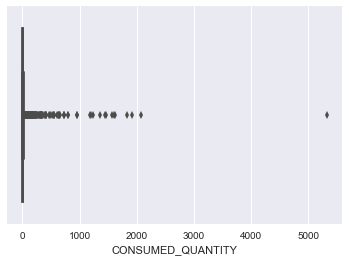

In [26]:
one_type_treatment_valid_tcs['CONSUMED_QUANTITY'].describe()
sns.boxplot(one_type_treatment_valid_tcs['CONSUMED_QUANTITY'])

Text(0,0.5,'Counts of patients')

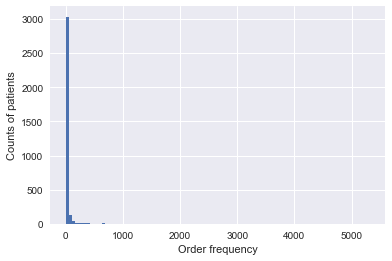

In [27]:
ax = one_type_treatment_valid_tcs['CONSUMED_QUANTITY'].hist(bins=100)
ax.set_xlabel('Consumed quantity')
ax.set_ylabel('Counts of order')

Take deeper look at those orders whose consumed quantity is larger than 500

In [28]:
one_type_treatment_valid_tcs_cqmax = one_type_treatment_valid_tcs.query(
        'CONSUMED_QUANTITY>500')
one_type_treatment_valid_tcs_cqmax['UNIT_STRENGTH'].describe()

count     32.000000
mean      33.260417
std      140.273152
min        4.000000
25%        4.000000
50%        4.000000
75%       10.000000
max      800.000000
Name: UNIT_STRENGTH, dtype: float64

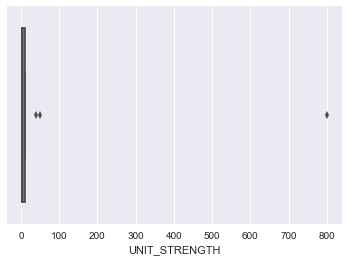

In [29]:
sns.boxplot(one_type_treatment_valid_tcs_cqmax['UNIT_STRENGTH'])

### Unit strength

In [30]:
one_type_treatment_valid_tcs['UNIT_STRENGTH'].describe()

count    3309.000000
mean      135.255447
std       254.992467
min         0.050000
25%         4.000000
50%        10.000000
75%        50.000000
max      1200.000000
Name: UNIT_STRENGTH, dtype: float64

Unit strength is equal or greater than 800

In [31]:
one_type_treatment_valid_tcs_us800 = one_type_treatment_valid_tcs.query(
        'UNIT_STRENGTH>=800')

In [32]:
one_type_treatment_valid_tcs_us800['CONSUMED_QUANTITY'].describe()

count    337.000000
mean      11.510386
std       37.676814
min        1.000000
25%        1.000000
50%        3.000000
75%        7.000000
max      518.000000
Name: CONSUMED_QUANTITY, dtype: float64

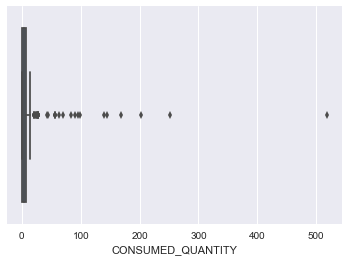

In [33]:
sns.boxplot(one_type_treatment_valid_tcs_us800['CONSUMED_QUANTITY'])

### Combine Diastolic blood pressure and medication

#### Diastolic blood pressure

In [35]:
Diastolic_BP = pd.read_csv(root_dir+'/vital_sign/Diastolic_BP.csv')

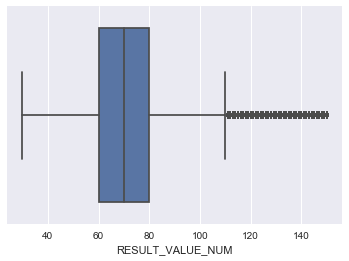

In [36]:
sns.boxplot(Diastolic_BP['RESULT_VALUE_NUM'])

Text(0,0.5,'Counts')

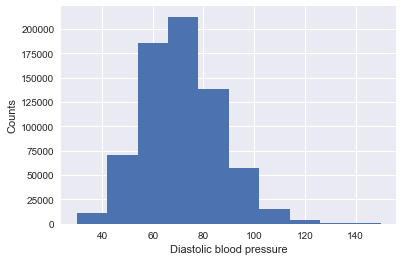

In [38]:
ax = Diastolic_BP['RESULT_VALUE_NUM'].plot.hist()
ax.set_xlabel('Diastolic blood pressure')
ax.set_ylabel('Counts')

In [39]:
Diastolic_BP = Diastolic_BP.drop('PATIENT_ID', 1)
Diastolic_BP['EVENT_DATE'] = pd.to_datetime(Diastolic_BP['EVENT_DATE'])
# Merge the Diastolic_BP with patient level table
Diastolic_BP = pd.merge(Diastolic_BP,
                        pat_enc_final[['PATIENT_SK', 'ENCOUNTER_ID']],
                        how='inner', on='ENCOUNTER_ID')

Among the 1839 patients, see how many have blood pressure.

In [84]:
Diastolic_BP = Diastolic_BP.sort_values(by=['PATIENT_SK', 'EVENT_DATE'])
one_type_treatment_patsk = one_type_treatment_valid_tcs['PATIENT_SK'].unique()
valid_pat_sk_indc = np.in1d(
        one_type_treatment_patsk, Diastolic_BP['PATIENT_SK'].unique())
valid_pat_sk = one_type_treatment_patsk[valid_pat_sk_indc]
print('The number of patients who only received one type of treatment,  with total consumed strength of the medication order > 0\
      and have blood pressure values: \n{}.'.format(
valid_pat_sk.shape[0]))

The number of patients who only received one type of treatment,  with total consumed strength of the medication order > 0      and have blood pressure values: 
467.


In [61]:
# Indicator of useful patient sks
ind_treat = one_type_treatment_valid_tcs['PATIENT_SK'].isin(valid_pat_sk)
one_type_treat_have_validbp = one_type_treatment_valid_tcs[ind_treat]
ind_bp = Diastolic_BP['PATIENT_SK'].isin(valid_pat_sk)
diastolic_valid_bp = Diastolic_BP[ind_bp]

##### Basic summary of measurement times of diastolic blood pressure

Measurement times  per patient

In [62]:
diastolic_valid_bp_grpby_pat = diastolic_valid_bp.groupby(['PATIENT_SK'])
meas_per_patient = diastolic_valid_bp_grpby_pat.size()
meas_per_patient.describe()

count     467.000000
mean      304.967880
std       342.057121
min         1.000000
25%        48.000000
50%       181.000000
75%       473.000000
max      2229.000000
dtype: float64

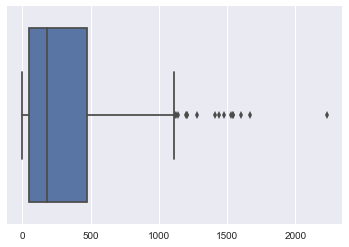

In [63]:
sns.boxplot(meas_per_patient)

Text(0,0.5,'Counts of patients')

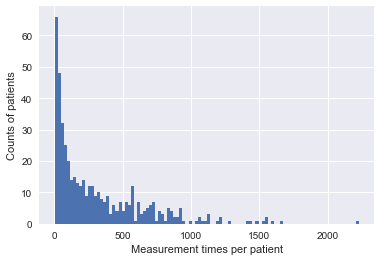

In [65]:
ax = meas_per_patient.plot.hist(bins=100)
ax.set_xlabel('Measurement times per patient')
ax.set_ylabel('Counts of patients')

Check the maxmium measurement times 2229

In [67]:
max_meas_index = meas_per_patient.idxmax()
max_meas_detail = diastolic_valid_bp[
        diastolic_valid_bp['PATIENT_SK'] == max_meas_index]
max_meas_detail

,ENCOUNTER_ID,RESULT_VALUE_NUM,EVENT_DATE,PATIENT_SK
615200,250346176,82,2013-03-17 20:00:00,15157186
615201,250346176,95,2013-02-10 14:45:00,15157186
615202,250346176,78,2013-03-19 17:00:00,15157186
615203,250346176,73,2013-03-16 02:00:00,15157186
615204,250346176,79,2013-03-07 06:00:00,15157186
615205,250346176,63,2013-03-12 20:00:00,15157186
615206,250346176,89,2013-02-21 05:00:00,15157186
615207,250346176,106,2013-02-09 13:00:00,15157186
615208,250346176,78,2013-03-01 07:30:00,15157186
615209,250346176,72,2013-02-27 18:15:00,15157186


#### Systolic blood pressure

In [91]:
Systolic_BP = pd.read_csv(root_dir+'/vital_sign/Systolic_BP.csv')

See how many patients that have both systolic blood pressure and diastolic blood pressure. Ans: 2388

In [72]:
Systolic_BP['PATIENT_SK'].nunique()  # 2388
Diastolic_BP['PATIENT_SK'].nunique()  # 2390
patient_sk_overlap_indic1 = np.in1d(Systolic_BP['PATIENT_SK'].unique(),
                                    Diastolic_BP['PATIENT_SK'].unique())
sum(patient_sk_overlap_indic1)  # 2388
patient_sk_overlap_indic2 = np.in1d(Diastolic_BP['PATIENT_SK'].unique(),
                                    Systolic_BP['PATIENT_SK'].unique())
sum(patient_sk_overlap_indic2)  # 2388
not_overlap_patientsk = Diastolic_BP['PATIENT_SK'].unique()[
        ~patient_sk_overlap_indic2]
not_overlap_patientsk_detail = Diastolic_BP[Diastolic_BP['PATIENT_SK'].isin(
        not_overlap_patientsk)]

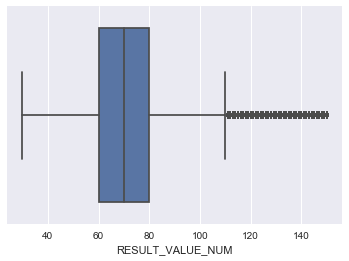

In [69]:
sns.boxplot(Diastolic_BP['RESULT_VALUE_NUM'])

Text(0,0.5,'Counts')

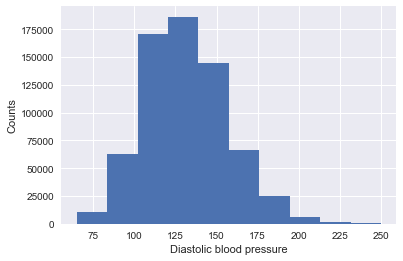

In [70]:
ax = Systolic_BP['RESULT_VALUE_NUM'].plot.hist()
ax.set_xlabel('Systolic blood pressure')
ax.set_ylabel('Counts')

In [71]:
Systolic_BP = Systolic_BP.drop('PATIENT_ID', 1)
Systolic_BP['EVENT_DATE'] = pd.to_datetime(Systolic_BP['EVENT_DATE'])
# Merge the Diastolic_BP with patient level table
Systolic_BP = pd.merge(Systolic_BP,
                        pat_enc_final[['PATIENT_SK', 'ENCOUNTER_ID']],
                        how='inner', on='ENCOUNTER_ID')

In [85]:
Systolic_BP = Systolic_BP.sort_values(by=['PATIENT_SK', 'EVENT_DATE'])
one_type_treatment_patsk = one_type_treatment_valid_tcs['PATIENT_SK'].unique()
valid_pat_sk_indc = np.in1d(
        one_type_treatment_patsk, Systolic_BP['PATIENT_SK'].unique())
valid_pat_sk = one_type_treatment_patsk[valid_pat_sk_indc]
print('The number of patients who only received one type of treatment,  with total consumed strength of the medication order > 0\
      and have systolic blood pressure values: \n{}.'.format(
valid_pat_sk.shape[0]))

The number of patients who only received one type of treatment,  with total consumed strength of the medication order > 0      and have blood pressure values: 
467.


In [86]:
# Indicator of useful patient sks
ind_treat = one_type_treatment_valid_tcs['PATIENT_SK'].isin(valid_pat_sk)
one_type_treat_have_validbp = one_type_treatment_valid_tcs[ind_treat]
ind_bp = Systolic_BP['PATIENT_SK'].isin(valid_pat_sk)
systolic_valid_bp = Systolic_BP[ind_bp]

##### Basic summary of measurement times of systolic blood pressure

Measurement times per patient

In [87]:
systolic_valid_bp_grpby_pat = systolic_valid_bp.groupby(['PATIENT_SK'])
sysmeas_per_patient = systolic_valid_bp_grpby_pat.size()
sysmeas_per_patient.describe()

count     467.000000
mean      308.792291
std       347.522114
min         1.000000
25%        48.000000
50%       182.000000
75%       477.500000
max      2223.000000
dtype: float64

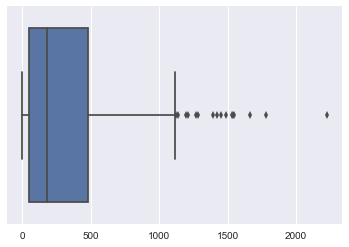

In [88]:
sns.boxplot(sysmeas_per_patient)

Text(0,0.5,'Counts of patients')

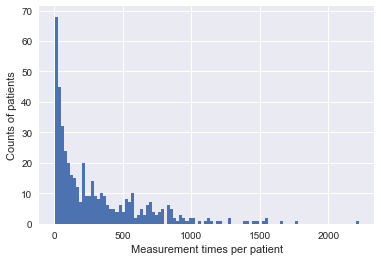

In [89]:
ax = sysmeas_per_patient.plot.hist(bins=100)
ax.set_xlabel('Measurement times per patient')
ax.set_ylabel('Counts of patients')

Check the maxmium measurement times 2223

In [90]:
max_sysmeas_index = sysmeas_per_patient.idxmax()
max_sysmeas_detail = systolic_valid_bp[
        systolic_valid_bp['PATIENT_SK'] == max_meas_index]
max_sysmeas_detail

,ENCOUNTER_ID,RESULT_VALUE_NUM,EVENT_DATE,PATIENT_SK
597287,250346176,210,2013-02-03 19:42:00,15157186
597195,250346176,206,2013-02-03 20:00:00,15157186
597007,250346176,176,2013-02-03 20:15:00,15157186
598575,250346176,159,2013-02-03 20:30:00,15157186
597257,250346176,189,2013-02-03 20:45:00,15157186
597587,250346176,189,2013-02-03 21:00:00,15157186
597172,250346176,97,2013-02-03 22:00:00,15157186
597014,250346176,148,2013-02-04 02:35:00,15157186
598269,250346176,141,2013-02-04 04:00:00,15157186
598565,250346176,139,2013-02-04 04:30:00,15157186


#### Trend of blood pressure

By introducing a threshold parameter, we can observe the trend of blood pressure at the time interval we are interested in. The shreshold could be 10 hours or 10 days. 

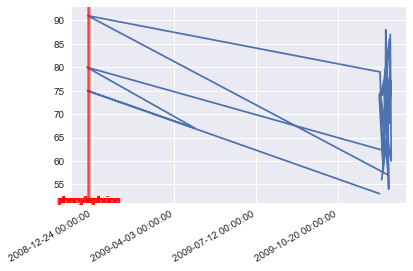

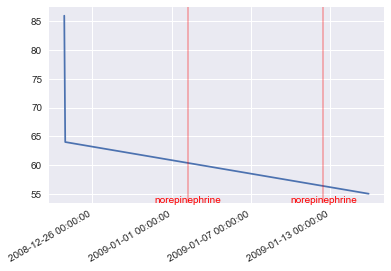

In [57]:
sample_patient_sk = np.random.choice(valid_pat_sk, 10)
for patient_sk in sample_patient_sk:
    sample_diasbp = Diastolic_BP[Diastolic_BP['PATIENT_SK'] == patient_sk]
    sample_med = one_type_treatment_valid_tcs[
        one_type_treatment_valid_tcs['PATIENT_SK'] == patient_sk]
    fig, ax = plt.subplots()
    ax.plot(sample_diasbp['EVENT_DATE'], sample_diasbp['RESULT_VALUE_NUM'])
    for i, val in enumerate(sample_med['MED_STARTED_DT_TM']):
        ax.axvline(x=sample_med['MED_STARTED_DT_TM'].iloc[i], alpha=0.3,
                   color='red')
        ax.text(sample_med['MED_STARTED_DT_TM'].iloc[i], ax.get_ylim()[0],
                sample_med['GENERIC_NAME'].iloc[i], ha='center', color='red')
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M:%S'))
        ax.fmt_xdata = DateFormatter('%Y-%m-%d %H:%M:%S')
        fig.autofmt_xdate()